In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/driver-drowsiness-dataset-ddd/Driver Drowsiness Dataset (DDD)/Non Drowsy/e0604.png
/kaggle/input/driver-drowsiness-dataset-ddd/Driver Drowsiness Dataset (DDD)/Non Drowsy/y0868.png
/kaggle/input/driver-drowsiness-dataset-ddd/Driver Drowsiness Dataset (DDD)/Non Drowsy/a1012.png
/kaggle/input/driver-drowsiness-dataset-ddd/Driver Drowsiness Dataset (DDD)/Non Drowsy/c0445.png
/kaggle/input/driver-drowsiness-dataset-ddd/Driver Drowsiness Dataset (DDD)/Non Drowsy/u0030.png
/kaggle/input/driver-drowsiness-dataset-ddd/Driver Drowsiness Dataset (DDD)/Non Drowsy/r0229.png
/kaggle/input/driver-drowsiness-dataset-ddd/Driver Drowsiness Dataset (DDD)/Non Drowsy/n0503.png
/kaggle/input/driver-drowsiness-dataset-ddd/Driver Drowsiness Dataset (DDD)/Non Drowsy/za0739.png
/kaggle/input/driver-drowsiness-dataset-ddd/Driver Drowsiness Dataset (DDD)/Non Drowsy/m0348.png
/kaggle/input/driver-drowsiness-dataset-ddd/Driver Drowsiness Dataset (DDD)/Non Drowsy/zc0313.png
/kaggle/input/driver-drowsin

# **Import relevant dependancies**

In [2]:
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras.models import Model
#from collections import counter

In [3]:
tf.random.set_seed(3)

In [4]:
!pip install split-folders
!pip install collections

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


ERROR: Could not find a version that satisfies the requirement collections (from versions: none)
ERROR: No matching distribution found for collections


In [5]:
path = "/kaggle/working/train_data"
os.makedirs(path,exist_ok=True)

# **Split in to train test and validation folders**

In [6]:
import splitfolders 

data = "/kaggle/input/driver-drowsiness-dataset-ddd/Driver Drowsiness Dataset (DDD)"
output_dir = "/kaggle/working/train_data"
splitfolders.ratio(data,output = output_dir,seed=1337,ratio=(0.8,0.15,0.05))

Copying files: 41793 files [04:53, 142.56 files/s]


# **Reading the data**

In [7]:
train_dir = '/kaggle/working/train_data/train'
test_dir = '/kaggle/working/train_data/test'
val_dir = '/kaggle/working/train_data/val'

In [8]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

In [9]:
train_batch = train_datagen.flow_from_directory(
    train_dir,
    target_size = (224,224),
    batch_size = 16,
    class_mode = 'binary',
    shuffle = True
)

Found 33434 images belonging to 2 classes.


In [10]:
test_batch = test_datagen.flow_from_directory(
    test_dir,
    target_size = (224,224),
    batch_size = 16,
    class_mode = 'binary',
    shuffle = True
)

Found 2091 images belonging to 2 classes.


In [11]:
val_batch = val_datagen.flow_from_directory(
    val_dir,
    target_size = (224,224),
    batch_size = 16,
    class_mode = 'binary',
    shuffle = True
)

Found 6268 images belonging to 2 classes.


In [12]:
from collections import Counter 

train_class_indices = train_batch.class_indices
test_class_indices = test_batch.class_indices
val_class_indices = val_batch.class_indices

train_class_labels = train_batch.classes
test_class_labels = test_batch.classes
val_class_labels = val_batch.classes

train_class_counts = Counter(train_class_labels)
test_class_counts = Counter(test_class_labels)
val_class_counts = Counter(val_class_labels)

print("Class names for train:\n",train_class_indices)
print("Class Counts for train:\n",train_class_counts)
print(end="\n")

print("Class names for test:\n",test_class_indices)
print("Class Counts for test:\n",test_class_counts)
print(end="\n")

print("Class names for validation:\n",val_class_indices)
print("Class Counts for validation:\n",val_class_counts)
print(end="\n")

Class names for train:
 {'Drowsy': 0, 'Non Drowsy': 1}
Class Counts for train:
 Counter({0: 17878, 1: 15556})

Class names for test:
 {'Drowsy': 0, 'Non Drowsy': 1}
Class Counts for test:
 Counter({0: 1118, 1: 973})

Class names for validation:
 {'Drowsy': 0, 'Non Drowsy': 1}
Class Counts for validation:
 Counter({0: 3352, 1: 2916})



Pixels of the image after normalization: 

[[[0.454902   0.40784317 0.27058825]
  [0.454902   0.40784317 0.27058825]
  [0.454902   0.40784317 0.27058825]
  ...
  [0.70980394 0.65882355 0.5647059 ]
  [0.75294125 0.69803923 0.6       ]
  [0.7725491  0.72156864 0.61960787]]

 [[0.454902   0.40784317 0.27058825]
  [0.454902   0.40784317 0.27058825]
  [0.454902   0.40784317 0.27058825]
  ...
  [0.67058825 0.6156863  0.5254902 ]
  [0.7294118  0.6784314  0.5803922 ]
  [0.7607844  0.7137255  0.60784316]]

 [[0.454902   0.40784317 0.27058825]
  [0.454902   0.40784317 0.27058825]
  [0.45098042 0.4039216  0.26666668]
  ...
  [0.5921569  0.5372549  0.44705886]
  [0.6901961  0.63529414 0.54509807]
  [0.7411765  0.6862745  0.59607846]]

 ...

 [[0.5294118  0.49803925 0.41960788]
  [0.5294118  0.49803925 0.41960788]
  [0.53333336 0.5058824  0.42352945]
  ...
  [0.17254902 0.04705883 0.02352941]
  [0.18431373 0.0627451  0.0509804 ]
  [0.19215688 0.07450981 0.06666667]]

 [[0.53333336 0.5058824  0.4274

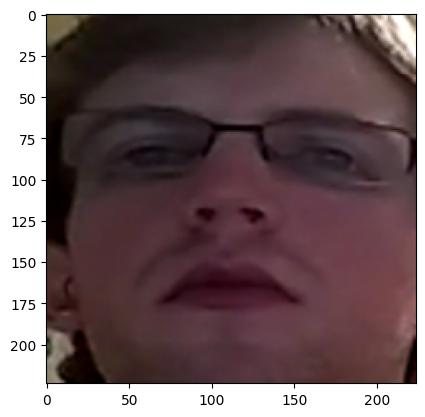

In [17]:
images, pixels = next(train_batch)
print(f"Pixels of the image after normalization: \n\n{images[15]}")
plt.imshow(images[15])
plt.show()